In [10]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from sklearn import model_selection
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os


In [11]:
#Set path to data
path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad"
# path_rna = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/RNA_concat_lipids.h5ad"


In [12]:
# Set task/dataset name and path to store (keep MSI since it will be used for storing)
dataset_name  = "V11L12-038_A1.MSI_MOSCOT_paired_hvg"
store_dir = "/lustre/groups/ml01/workspace/eirini.giannakoulia/hand_prep/"
# name of final data will be a combination of task_name and topN abundant metabs

In [13]:
adata_msi_full = sc.read_h5ad(path_msi)
# adata_rna_full = sc.read_h5ad(path_rna)

### Prepare MSI data

In [14]:
adata_msi_full

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [15]:
adata_msi_full.var_names_make_unique()

In [16]:
adata_msi_full

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Here you can subset metabolites for noise  
e.g.:  
Remove m/z below FMP10, because most likely this is noise:  
```python
adata_msi_full.var_names  
adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()

In [17]:
adata_msi_full.var_names

Index(['137.023795', '154.026815', '162.11293999999998', '169.07619',
       '169.076575', '170.07992000000002', '170.08429999999998', '171.09223',
       '176.00807', '176.00849',
       ...
       '968.5382649999999', '968.564535', '969.56285', '973.551305',
       '980.533075', '981.582135', '982.519885', '983.879985', '985.53971',
       '989.5183649999999'],
      dtype='object', length=500)

In [18]:
adata_msi

NameError: name 'adata_msi' is not defined

In [ ]:
# adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()
# a

In [ ]:
adata_msi = adata_msi_full.copy()

AnnData object with n_obs × n_vars = 2681 × 444
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [9]:
adata_msi

NameError: name 'adata_msi' is not defined

Quality control

In [ ]:
# sc.pp.calculate_qc_metrics(adata_msi, inplace=True)

IndexError: Positions outside range of features.

<Axes: xlabel='total_counts', ylabel='Count'>

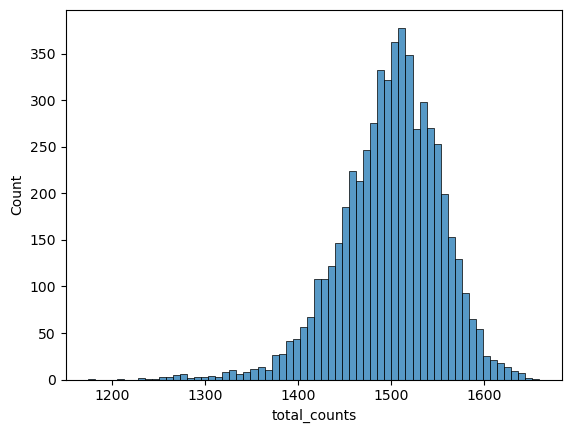

In [ ]:
sns.histplot(adata_msi.obs.total_counts) #This sums all the metabolites m/z ratios for each cell

<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

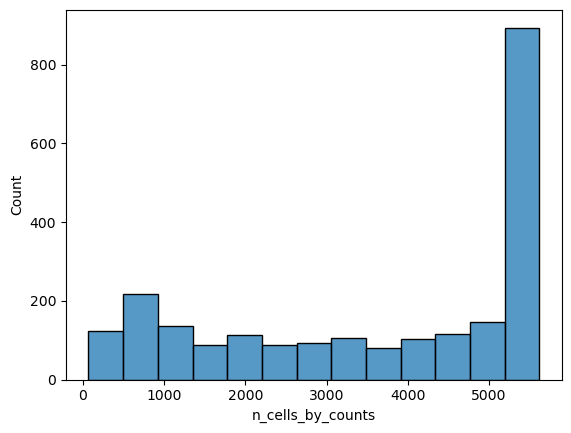

In [ ]:
sns.histplot(adata_msi.var.n_cells_by_counts) #This sums all the cells for each metabolite m/z ratio
# we notice that o

In [ ]:
adata_msi.var.n_cells_by_counts.describe()

count    2304.000000
mean     3681.755208
std      1938.285878
min        71.000000
25%      1858.750000
50%      4350.500000
75%      5581.250000
max      5618.000000
Name: n_cells_by_counts, dtype: float64

### Let's identify most spatialy variable metabolites

In [ ]:
adata_msi

AnnData object with n_obs × n_vars = 5618 × 2304
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

MoranI already present, but just for completeness let's go for the procedure from beginning



In [ ]:
# Identify top 5 most spatially variable metabolomes using Moran's I
sq.gr.spatial_neighbors(adata_msi, spatial_key='spatial_warp')
sq.gr.spatial_autocorr(adata_msi)


Do a sorting based first on index, then on Benjamini Hochberg FDR correction pvalue and select the top 30

In [ ]:
adata_msi.uns["moranI"]

,I,pval_norm,var_norm,pval_norm_fdr_bh
353.023935,0.498208,0.000000,0.000051,0.000000
335.013615,0.475016,0.000000,0.000051,0.000000
364.90382,0.459445,0.000000,0.000051,0.000000
364.90545999999995,0.438676,0.000000,0.000051,0.000000
364.902325,0.419868,0.000000,0.000051,0.000000
...,...,...,...,...
802.92662,-0.005061,0.246608,0.000051,0.256008
871.660705,-0.005620,0.222557,0.000051,0.232605
985.53971,-0.005772,0.216260,0.000051,0.226535
866.70318,-0.008023,0.135509,0.000051,0.144897


In [ ]:
top_30_spat = adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_values(by=["I", "pval_norm_fdr_bh"], ascending=[False, True]).index[:30]


Mini correction for known matrix peaks, select matrix and mode


In [ ]:
mz_values = adata_msi.var_names.astype(float).to_numpy()
mz_values

array([288.927535, 289.03455 , 289.922755, ..., 992.614545, 994.56201 ,
       996.51046 ])

In [ ]:
dhb_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_positive[None, :]).min(axis=1) <= 0.1])
found_peaks_str = set(map(str, found_peaks))

# dhb_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


# fmp10_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_positive[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


# fmp10_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


In [21]:
found_peaks

set()

In [22]:
top_30_spat_filtered = [mz for mz in top_30_spat if mz not in found_peaks_str]
print(top_30_spat_filtered, len(top_30_spat_filtered))

['353.023935', '335.013615', '364.90382', '364.90545999999995', '364.902325', '566.98614', '845.51016', '844.505525', '655.931325', '838.6165', '848.6320350000001', '307.043815', '830.500175', '296.06595500000003', '343.05333', '866.6484849999999', '840.4292350000001', '839.6182200000001', '872.54763', '348.92984', '375.00721', '864.6305600000001', '375.00595', '849.639235', '802.46901', '822.63419', '703.56658', '867.6533999999999', '852.6320900000001', '400.342015'] 30


In [23]:
# ['203.05299000000002',
#  '162.11293999999998',
#  '214.01164',
#  '280.092375',
#  '845.51016',
#  '251.9674',
#  '353.023935',
#  '251.96654999999998',
#  '617.9799350000001',
#  '297.070615']

In [24]:
top_5_spat_metabolites = top_30_spat_filtered[:5]
top_10_spat_metabolites = top_30_spat_filtered[:10]
top_20_spat_metabolites = top_30_spat_filtered[:20]
adata_msi_top5_spat = adata_msi[:, adata_msi.var_names.isin(top_5_spat_metabolites)].copy()
adata_msi_top10_spat = adata_msi[:, adata_msi.var_names.isin(top_10_spat_metabolites)].copy()
adata_msi_top20_spat = adata_msi[:, adata_msi.var_names.isin(top_20_spat_metabolites)].copy()



/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata_msi_top5_spat.write(os.path.join(store_dir, f"{dataset_name}_top5spatvar.h5ad"))
adata_msi_top10_spat.write(os.path.join(store_dir, f"{dataset_name}_top10spatvar.h5ad"))
adata_msi_top20_spat.write(os.path.join(store_dir, f"{dataset_name}_top20spatvar.h5ad"))

In [29]:
adata_msi_top5_spat

AnnData object with n_obs × n_vars = 5618 × 5
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors', 'moranI'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

To use in big pipeline split in train and test

In [ ]:
task_name = "V11L12-038_A1_MOSCOT_paired_hvg"
base_dir = f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_top10_spatvar"

In [31]:
# adata_msi_top5_spat_train = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "train"].copy()
# adata_msi_top5_spat_test = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "test"].copy()

# for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
#     adata_msi_top5_spat_train.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_train.h5ad"))
#     adata_msi_top5_spat_test.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_test.h5ad"))


In [ ]:
adata_msi_top10_spat_train = adata_msi_top10_spat[adata_msi_top10_spat.obs["half_split"]=="train"].copy()
adata_msi_top10_spat_test = adata_msi_top10_spat[adata_msi_top10_spat.obs["half_split"]=="test"].copy()

for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    # Create the directory if it doesn't exist
    out_dir = os.path.join(base_dir, feat_sel)
    os.makedirs(out_dir, exist_ok=True)

    # Write the files
    adata_msi_top10_spat_train.write(os.path.join(out_dir, "msi_dataset_train.h5ad"))
    adata_msi_top10_spat_test.write(os.path.join(out_dir, "msi_dataset_test.h5ad"))


/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [33]:
adata_msi_top20_spat

AnnData object with n_obs × n_vars = 5618 × 20
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors', 'moranI'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
adata_msi_top20_spat_train = adata_msi_top20_spat[adata_msi_top20_spat.obs["half_split"]=="train"].copy()
adata_msi_top20_spat_test = adata_msi_top20_spat[adata_msi_top20_spat.obs["half_split"]=="test"].copy()

for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    out_dir = os.path.join(base_dir, feat_sel)
    os.makedirs(out_dir, exist_ok=True)
    
    adata_msi_top20_spat_train.write(os.path.join(out_dir, "msi_dataset_train.h5ad"))
    adata_msi_top20_spat_test.write(os.path.join(out_dir, "msi_dataset_test.h5ad"))
